<h1 style="color:#3498DB">Augmentation Cats Dogs</h1>

In [1]:
import os
import math
import zipfile
import warnings
import random
import wget
import datetime

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline
%load_ext tensorboard
warnings.filterwarnings('ignore')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Download The Archive File</h1>

In [ ]:
# !wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [2]:
# wget.download('https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Extract The Archive</h1>

In [3]:
# Extract the archive
zip_file_name = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_file_name, 'r')
zip_ref.extractall('tmp\\')
zip_ref.close()

# Assign training and validation set directories

train_dir = os.path.join('tmp\\cats_and_dogs_filtered', 'train')
validation_dir = os.path.join('tmp\\cats_and_dogs_filtered', 'validation')

train_dir, validation_dir

('tmp\\cats_and_dogs_filtered\\train',
 'tmp\\cats_and_dogs_filtered\\validation')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Display Some Images</h1>

In [4]:
# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')


# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

print('total training cat images :', len(os.listdir(train_cats_dir)))
print('total training dog images :', len(os.listdir(train_dogs_dir)))

print('total validation cat images :', len(os.listdir(validation_cats_dir)))
print('total validation dog images :', len(os.listdir(validation_dogs_dir)))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


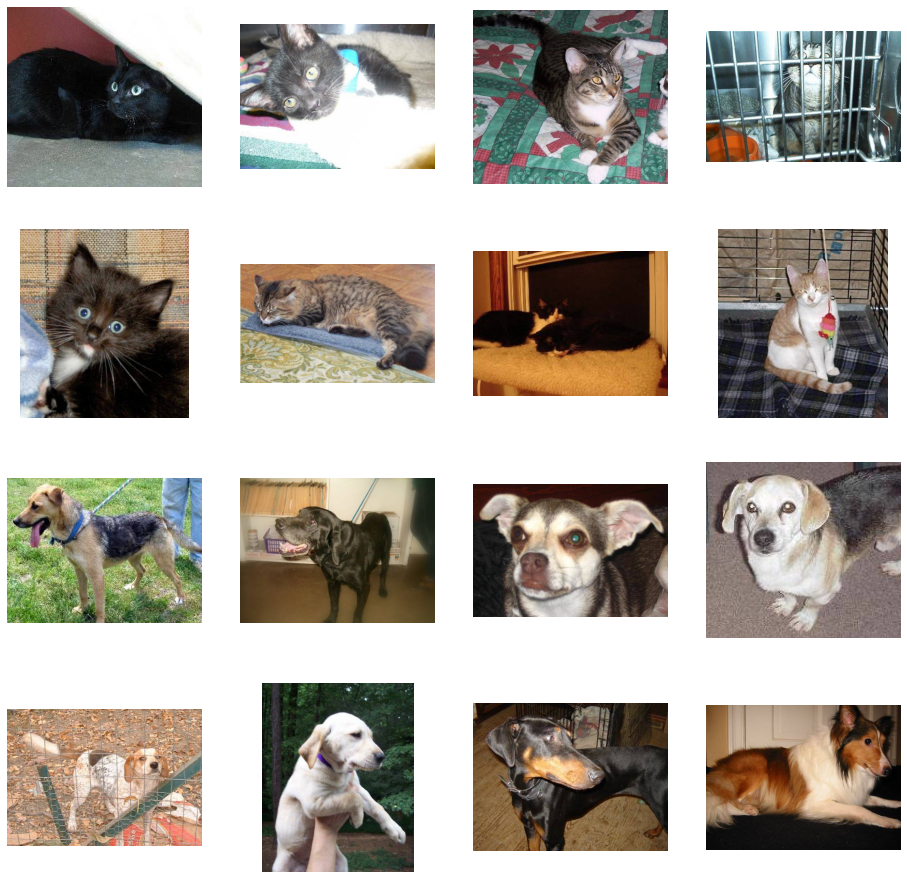

In [6]:
cats_imgs = os.listdir(train_cats_dir)
dogs_imgs = os.listdir(train_dogs_dir)

def randompic(file,names):
    return(os.path.join(file, names[random.randint(0,len(names)-1)]))

eight_cats = [randompic(train_cats_dir, cats_imgs) for _ in range(8)]
eight_dogs = [randompic(train_dogs_dir, dogs_imgs) for _ in range(8)]


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(16, 16)

for i , img_path in enumerate(eight_cats + eight_dogs):
    
    # Set up subplot; subplot indices start at 1
    plt.subplot(4,4, i+1)
    
    plt.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(mpimg.imread(img_path))

plt.savefig('tmp\\some_training_imgs.jpg')
plt.show()

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Build The Model</h1>

In [7]:
def create_model():
    '''Creates a CNN with 4 convolutional layers'''

    model = keras.Sequential([
                              keras.Input(shape=(150, 150, 3)),

                              layers.Conv2D(16, (3,3), activation='relu'),
                              layers.MaxPooling2D(2,2),

                              layers.Conv2D(32, (3,3), activation='relu'),
                              layers.MaxPooling2D(2,2),

                              layers.Conv2D(128, (3,3), activation='relu'), 
                              layers.MaxPooling2D(2,2),

                              layers.Conv2D(128, (3,3), activation='relu'), 
                              layers.MaxPooling2D(2,2),

                              layers.Flatten(),
                              
                              layers.Dense(512, activation='relu'),
                              
                              layers.Dense(1, activation='sigmoid')
                              ])
    
    model.compile(
                  optimizer = 'RMSprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy']
                  )
    
    return model

<h3 style="color:#3498DB">Model summary</h3>

In [8]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

<h3 style="color:#3498DB">ImageDataGenerator</h3>

In [25]:
from keras.preprocessing.image import ImageDataGenerator

# Generator Objects
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flowing from dir

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    save_to_dir='tmp\\cat_and_dogs_aug',
                                                    save_prefix='aug'
                                                    )

validation_generator = validation_datagen.flow_from_directory(
                                                              validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary'
                                                              )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h3 style="color:#3498DB">Tensorboard callback class</h3>

In [26]:
project_name = 'Augmentation_cats_dogs'
log_dir_customized = "tmp\\logs\\"+project_name+"\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
Tensorboard_callback = TensorBoard(
                                   log_dir=log_dir_customized,
                                   histogram_freq=1,
                                   write_graph=True,
                                   write_images=True,
                                   write_steps_per_second=True,
                                   profile_batch=1,
                                   embeddings_freq=1,
                                   )

<h3 style="color:#3498DB">Create a model object and train it</h3>

In [28]:
model = create_model()

history = model.fit(
                    train_generator,
                    steps_per_epoch=20,
                    epochs=5,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1,
                    callbacks=[Tensorboard_callback]
                    )

Epoch 1/5
20/20 [==============================] - 31s 1s/step - loss: 0.7570 - accuracy: 0.4800 - val_loss: 0.6911 - val_accuracy: 0.5620
Epoch 2/5
20/20 [==============================] - 27s 1s/step - loss: 0.6929 - accuracy: 0.5175 - val_loss: 0.6891 - val_accuracy: 0.6000
Epoch 3/5
20/20 [==============================] - 28s 1s/step - loss: 0.6908 - accuracy: 0.5375 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 4/5
20/20 [==============================] - 28s 1s/step - loss: 0.6863 - accuracy: 0.5600 - val_loss: 0.6870 - val_accuracy: 0.5380
Epoch 5/5
20/20 [==============================] - 29s 1s/step - loss: 0.7118 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.5160


In [ ]:
# %tensorboard --logdir tmp/logs/Augmentation_cats_dogs

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h3 style="color:#3498DB">Plot Loss and Accuracy</h3>

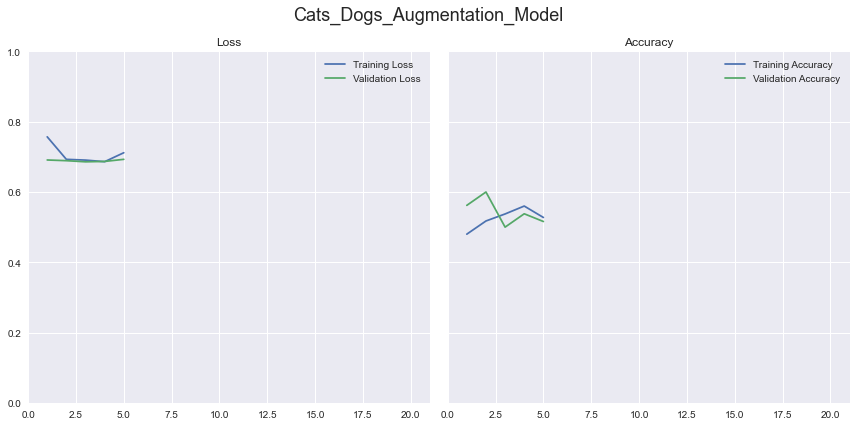

In [31]:
ModelName = 'Cats_Dogs_Augmentation_Model'

def plot_loss_accuracy(modelhistory, modelname):
    
    loss     = modelhistory.history['loss']
    val_loss = modelhistory.history['val_loss']
    acc      = modelhistory.history['accuracy']
    val_acc  = modelhistory.history['val_accuracy']

    epochs   = range(1,len(acc)+1) # Get number of epochs

    plt.style.use('seaborn')
    
    # Create Subplots System
    fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)

    # Change Figure Size
    fig.set_size_inches(12, 6)

    # Fig Name
    fig.suptitle(modelname, fontsize=18)
    
    # First Axies
    ax1.plot(epochs, loss, label="Training Loss")
    ax1.plot(epochs, val_loss, label="Validation Loss")
    ax1.set_title('Loss')
    ax1.set_xlim(0,21.0)
    ax1.set_ylim(0,1.0)
    ax1.legend()

    # Second Axies
    ax2.plot(epochs, acc, label="Training Accuracy")
    ax2.plot(epochs, val_acc, label="Validation Accuracy")
    ax2.set_title('Accuracy')
    ax2.set_xlim(0,21.0)
    ax2.legend()

    # Change Padding to Tight
    plt.tight_layout()

    # Show The Figure
    plt.show()

    # Save The Figure To JPG File
    fig.savefig('tmp\\'+modelname+'.jpg')
    
plot_loss_accuracy(history, ModelName)

<h3 style="color:#3498DB">Save Model To h5 File</h3>

In [30]:
model.save('tmp\\'+ModelName+'.h5')

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>

<h1 style="color:#3498DB">Test The Model</h1>

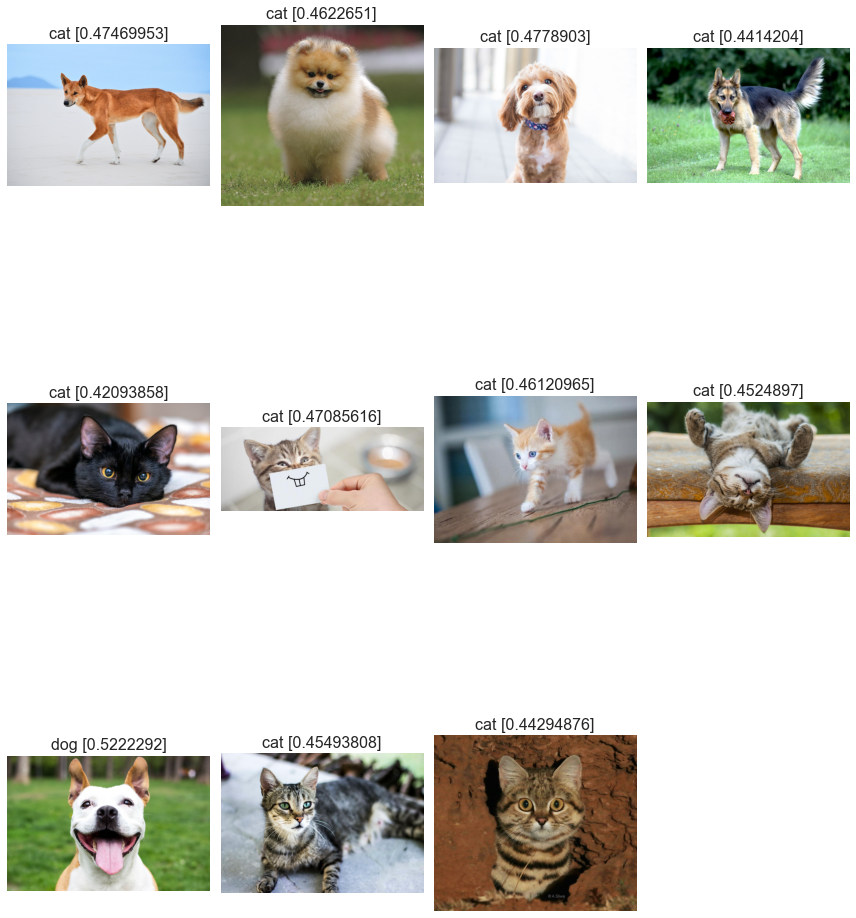

In [34]:
allimgs = [os.path.join('tmp\\cats_dogs_test_imgs', im) for im in os.listdir('tmp\\cats_dogs_test_imgs')]

def testcurrentimg(x):
    
    ImgPath = allimgs[x]

    img = load_img(ImgPath, target_size=(150, 150))
    x = img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    image = np.vstack([x])

    classes = model.predict(image)

    if classes[0] > 0.5:
        return(f'dog {classes[0]}')
    else:
        return(f'cat {classes[0]}')


# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = math.ceil(len(allimgs)/4)

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(nrows*4, 16)

for i, img_path in enumerate(allimgs):
    
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, 4, i + 1)
    
    sp.axis('Off') # Don't show axes (or gridlines)

    plt.title(testcurrentimg(i), fontsize=16)
    plt.imshow(mpimg.imread(img_path))

# Change Padding to Tight
plt.tight_layout()

plt.show()

In [ ]:
# ## CODE BLOCK FOR NON-SAFARI BROWSERS
# ## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

# import numpy as np

# from google.colab import files
# from keras.preprocessing import image

# uploaded=files.upload()

# for fn in uploaded.keys():
 
#     # predicting images
#     path='/content/' + fn
#     img=image.load_img(path, target_size=(150, 150))
  
#     x=image.img_to_array(img)
#     x /= 255
#     x=np.expand_dims(x, axis=0)
#     images = np.vstack([x])
  
#     classes = model.predict(images, batch_size=10)
  
#     print(classes[0])
  
#     if classes[0]>0.5:
#         print(fn + " is a dog")
#     else:
#         print(fn + " is a cat")

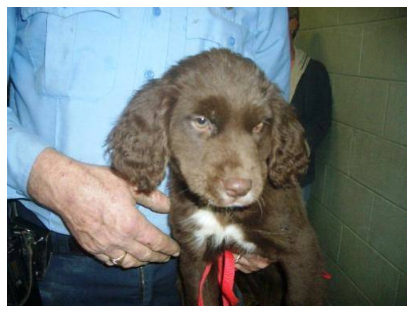

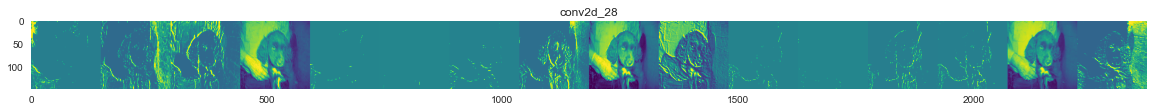

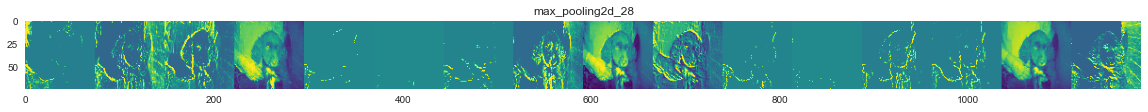

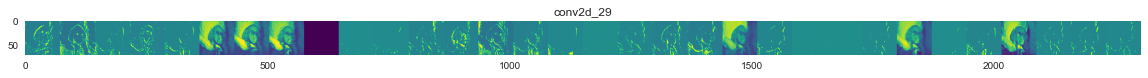

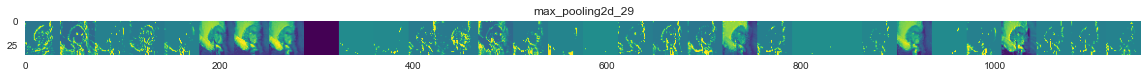

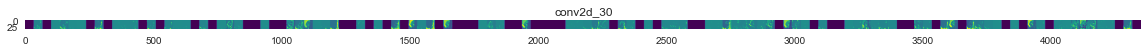

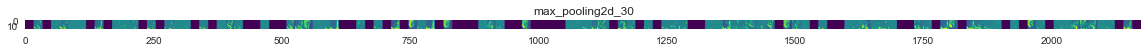

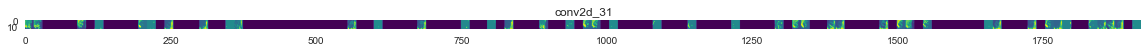

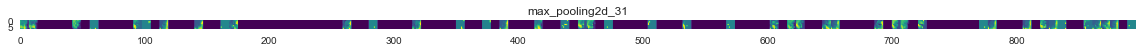

In [32]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in cats_imgs]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in dogs_imgs]

img_path = random.choice(cat_img_files + dog_img_files)
plt.axis('Off')
plt.imshow(mpimg.imread(img_path))

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:
    
        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )

<h3 style=color:#3498DB>///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////</h3>